
Dataset → CIFAR10 dataset \
Pooling Operation Details → AvgPool
# **MODEL DETAILS:**
Teacher Network Layers = 10 conv layers and 1 pooling layer.\
Student Network = 3 conv layers + 1 pool layer\
Fully-Connected layers (in both) = 1 FC layer with 256 nodes.

# **Step 1 -> Import Required Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Step 2 -> Load the CIFAR10 dataset**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the data transformation pipeline
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR10 dataset and apply the transformation pipeline
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Calculate the sizes of the training, validation, and testing datasets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and testing datasets
trainset, valset, testset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for the training, validation, and testing datasets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 105528188.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# **Step 3 ->  Define the Teacher Network**

In [ ]:
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool = nn.AvgPool2d(2)
        self.fc = nn.Linear(512, 256)
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.conv8(x)))
        x = F.relu(self.conv9(x))
        x = self.pool(F.relu(self.conv10(x)))
        x = x.view(-1, 512)
        x = self.fc(x)
        x = self.output(x)
        return x

# **Step 4 -> Define the Student Network**

In [ ]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.AvgPool2d(2,2)
        self.fc = nn.Linear(256*16*16, 256)
        self.output = nn.Linear(256,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        x = self.pool(x)
        x = x.view(-1, 256*16*16)
        x = self.fc(x)
        x = self.output(x)
        return x

# **Step 6 -> Train the Teacher Network**

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
teacher_net = TeacherModel().to(device)
optimizer = optim.Adam(teacher_net.parameters(), lr=0.001)
def train_teacher(teacher_net):
    train_losses = []
    train_accs = []

    for epoch in range(10):
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(10))

        with tqdm(total=len(trainloader)) as pbar:
            for i, data in enumerate(trainloader):

                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = teacher_net(images.cuda())
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                                 Accuracy='{0:.4f}'.format(float(train_acc.item()/(128.0*(i+1)))))
                pbar.update(1)
               
        epoch_loss = train_loss / len(trainloader)
        epoch_acc = 100.0 * float(train_acc.item()) / (len(trainloader) * 128.0)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)


    return train_accs, train_losses

In [ ]:
teacher_accs, teacher_losses = train_teacher(teacher_net)


Epoch:  1 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/274 [00:00<?, ?it/s]

# **Step 7 -> Test the Teacher Network**

In [ ]:
def evaluate(model, data_loader, device=device):
    model.eval()

    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss += nn.CrossEntropyLoss()(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).sum().item()

    loss /= len(data_loader)
    accuracy = 100. * correct / total

    return loss, accuracy

Evaluating the performance on teacher network using testdata

In [ ]:
evaluate(teacher_net, testloader, device)

(0.8086345063734658, 73.42)

# **Step 8 -> Train the Student Network**

In [ ]:
student_net = StudentModel().to(device)

In [ ]:
trainloader_one = DataLoader(trainset, batch_size=1, shuffle=True)
inputs, labels = next(iter(trainloader_one))
inputs, labels = inputs.to(device), labels.to(device)
outputs = student_net(inputs)
outputs

tensor([[-0.0115, -0.0031, -0.0270, -0.0888,  0.0491, -0.0047, -0.0040, -0.0601,
          0.0020,  0.0505]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
output2 = teacher_net(inputs)
output2

tensor([[-0.0084, -4.9822,  2.3605,  2.5717,  1.3467,  2.4381, -0.7637,  1.5387,
         -2.1977, -2.8033]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
temperature = 4
alpha = 0.7

In [ ]:
optimizer = optim.Adam(student_net.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
student_losses = []
student_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(trainloader)) as pbar:
        for i, data in enumerate(trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = teacher_net(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(128.0*(i+1)))))
            pbar.update(1)
    student_losses.append(train_loss)
    student_accs.append(train_acc.item()/len(trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/274 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



Epoch:  2 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/274 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/274 [00:00<?, ?it/s]

In [ ]:
student_accs = [i*100 for i in student_accs]

In [ ]:
student_accs

[45.72,
 61.04571428571428,
 67.49142857142857,
 71.5942857142857,
 75.05428571428571,
 77.98285714285714,
 80.49714285714286,
 83.69428571428571,
 86.94,
 90.01428571428572]

In [ ]:
student_losses = [i/len(trainloader) for i in student_losses]

In [ ]:
student_losses

[0.8298234619798451,
 0.5640116606968163,
 0.4623523761321158,
 0.4015556561903362,
 0.361161532954578,
 0.32379692075026295,
 0.2951144179070953,
 0.26213545422919476,
 0.23362984943346385,
 0.20543714998847376]

In [ ]:
teacher_accs

[18.504790145985403,
 32.065465328467155,
 44.15488138686131,
 55.18932481751825,
 62.46008211678832,
 67.63800182481752,
 71.16218065693431,
 75.01710766423358,
 78.05086678832117,
 80.58565237226277]

In [ ]:
teacher_losses

[1.999266734958565,
 1.6991981463710757,
 1.4449240413025348,
 1.2104207718894429,
 1.0328332420683255,
 0.9049178311859605,
 0.7997584038407263,
 0.6962691012525211,
 0.6153689928515984,
 0.5447304356489738]

# **Step 9 -> Test the Student Network**

Evaluating the performance on student model (test set)

In [ ]:
evaluate(student_net, testloader, device)

(0.8596124611323392, 71.07)

# **Step 10 -> Plots for comparing Teacher and Student networks**
(train set)

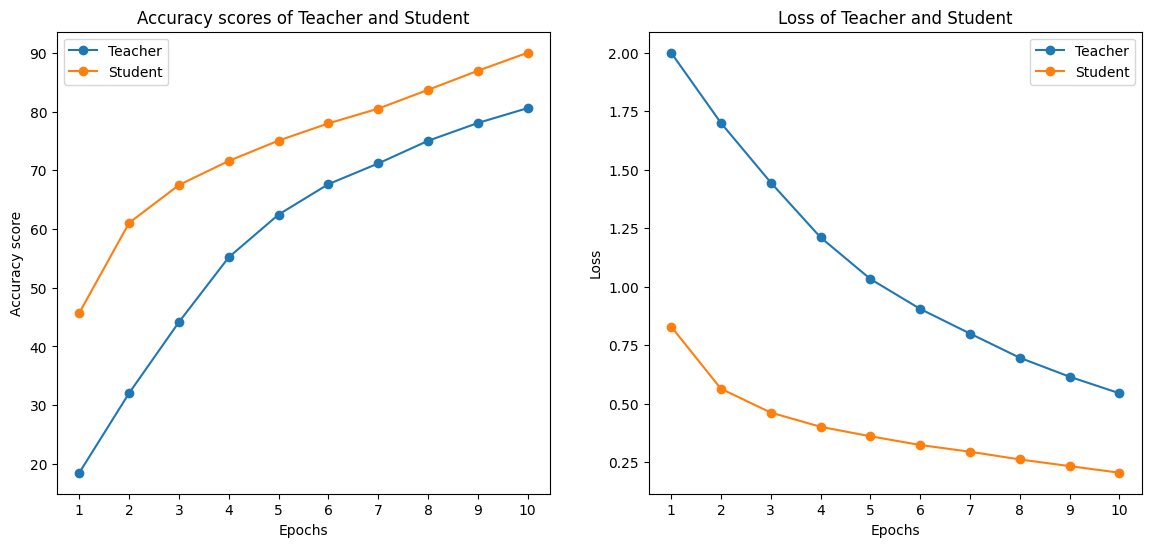

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], teacher_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], teacher_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

# **Step 10 -> Plots for comparing Teacher and Student networks**
(valid set)

In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 4
alpha = 0.7

In [ ]:
optimizer = optim.Adam(student_net.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
student_losses = []
student_accs = []

for epoch in range(num_epochs):
    valid_loss, valid_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(valloader)) as pbar:
        for i, data in enumerate(valloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = teacher_net(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # valid_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            valid_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(valid_acc.item()/(128.0*(i+1)))))
            pbar.update(1)
    student_losses.append(loss.item())
    student_accs.append((valid_acc.item()/len(valloader.dataset))*100)


Epoch:  1 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
student_accs

[27.800000000000004,
 44.24,
 52.0,
 58.14,
 63.94,
 69.66,
 74.72,
 78.92,
 80.9,
 81.08]

In [ ]:
student_losses

[0.8464062213897705,
 0.3497903347015381,
 0.18608921766281128,
 0.14709702134132385,
 0.12515908479690552,
 0.11263382434844971,
 0.11099649965763092,
 0.10528387874364853,
 0.14627040922641754,
 0.19597367942333221]

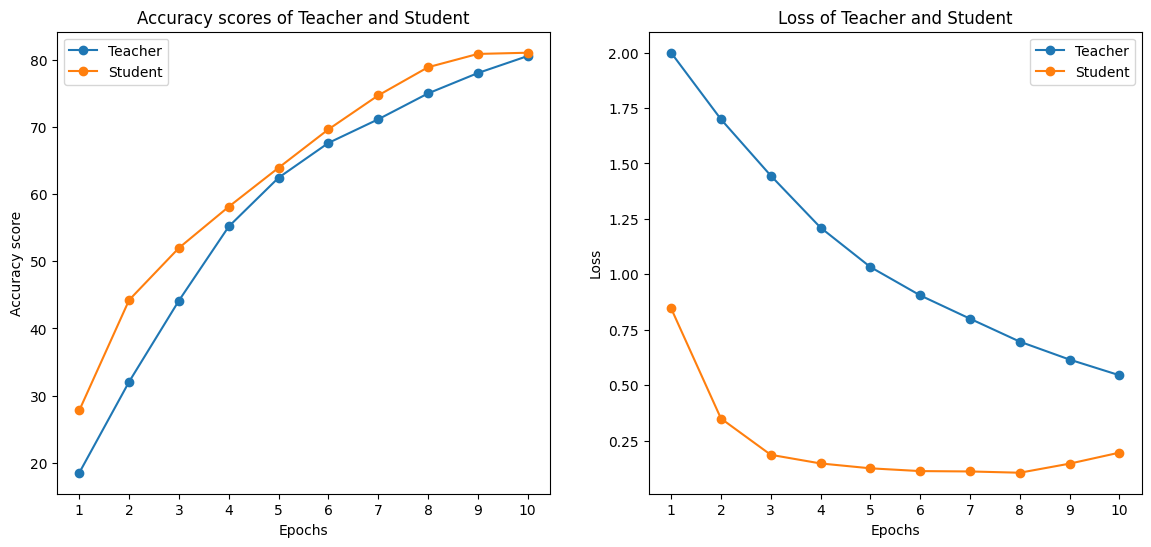

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
idx = [1,2,3,4,5,6,7,8,9,10]
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot(idx, teacher_accs, label="Teacher", marker='o')
ax1.plot(idx, student_accs, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: losses of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], teacher_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

In [ ]:
from torchsummary import summary

print(summary(teacher_net, input_size = (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2          [-1, 128, 32, 32]          73,856
         AvgPool2d-3          [-1, 128, 16, 16]               0
            Conv2d-4          [-1, 256, 16, 16]         295,168
            Conv2d-5          [-1, 512, 16, 16]       1,180,160
         AvgPool2d-6            [-1, 512, 8, 8]               0
            Conv2d-7            [-1, 512, 8, 8]       2,359,808
            Conv2d-8            [-1, 512, 8, 8]       2,359,808
         AvgPool2d-9            [-1, 512, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       2,359,808
           Conv2d-11            [-1, 512, 4, 4]       2,359,808
        AvgPool2d-12            [-1, 512, 2, 2]               0
           Conv2d-13            [-1, 512, 2, 2]       2,359,808
           Conv2d-14            [-1, 51

In [ ]:
print(summary(student_net, input_size = (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2          [-1, 128, 32, 32]          73,856
            Conv2d-3          [-1, 256, 32, 32]         295,168
         AvgPool2d-4          [-1, 256, 16, 16]               0
            Linear-5                  [-1, 256]      16,777,472
            Linear-6                   [-1, 10]           2,570
Total params: 17,150,858
Trainable params: 17,150,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 4.00
Params size (MB): 65.43
Estimated Total Size (MB): 69.44
----------------------------------------------------------------
None
